In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pandas as pd
from skimage import io, transform
from torch.optim import lr_scheduler
import torch.nn.functional as F

In [2]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
transform = transforms.Compose([
        transforms.Resize((600, 600)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
        

In [4]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-2])
        #self.features1 = nn.Sequential(*layers[:6])
        #self.features2 = nn.Sequential(*layers[6:])
        num_features = 2048
        self.classifier = nn.Sequential(nn.Linear(num_features, 5))
        self.bb = nn.Sequential(nn.Dropout(), 
                                nn.Linear(num_features, 1024), nn.ReLU(),
                                nn.Linear(1024, 512), nn.ReLU(),
                                nn.Linear(512, 256), nn.ReLU(),
                                nn.Linear(256, 128), nn.ReLU(),
                                nn.BatchNorm1d(128), 
                                nn.Dropout(), 
                                nn.Linear(128, 4), nn.Sigmoid())
        
    def forward(self, x):
        x = self.features(x)
        #x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.bb(x), self.classifier(x)

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
PATH = '../input/model-trained/model_aug.pt'

model = torch.load(PATH)

In [16]:
idx = 1
model.eval()
classes = {'0': 'NATURAL_IMAGE', '1': 'TABLE', '2':'SIGNATURE', '3': 'FIGURE', '4': 'LOGO'}
dataset_path = '../input/iit-ar-13k-dataset/test_images/test_images'
csv =  pd.read_csv('../input/labels-224/ch_graph_obj_test.csv')
img_name = os.path.join(dataset_path, csv.iloc[idx, 2])

# im = Image.open(img_name)
# display(im)
img = Image.open(img_name).convert("RGB")

img = transform(img)
img_tensor = img.unsqueeze_(0)
label = csv.iloc[idx, 18]
bound_boxes = csv.iloc[idx, 14:18]
resize_factors = np.array(csv.iloc[idx, 10:12].values)

bound_boxes = np.array([bound_boxes])/600
bound_boxes = bound_boxes.astype('float').reshape(4)
label = csv.iloc[idx, 18]

img = img.to(device)
pred_bb, pred_class = model(img)
_, pred = torch.max(pred_class, 1)

real_pred_bb = pred_bb*600
real_true_bb = bound_boxes*600
real_pred_bb = real_pred_bb[0].detach().cpu().numpy()

for i in range(4):
    if i%2==0:
        real_pred_bb[i] /= resize_factors[0]
        real_true_bb[i] /= resize_factors[0]
    else:
        real_pred_bb[i] /= resize_factors[1]
        real_true_bb[i] /= resize_factors[1]


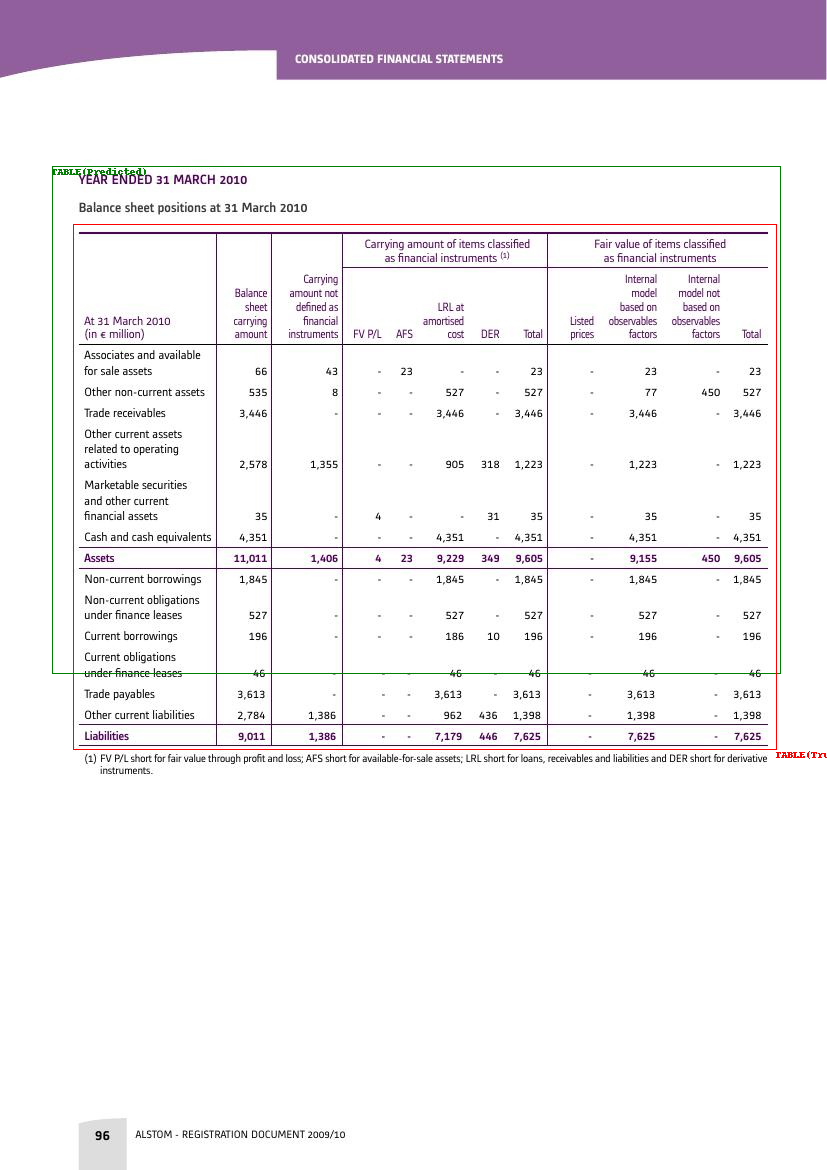

In [17]:
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

img = Image.open(img_name).convert("RGB") 

draw = ImageDraw.Draw(img)

draw.rectangle(((int(real_pred_bb[0]), int(real_pred_bb[1])),\
                (int(real_pred_bb[2]), int(real_pred_bb[3]))), outline="green")
draw.rectangle(((int(real_true_bb[0]), int(real_true_bb[1])), \
                (int(real_true_bb[2]), int(real_true_bb[3]))), outline="red")


draw.text((int(real_pred_bb[0]), int(real_pred_bb[1])), classes[str(pred.item())] +"(Predicted)", fill='green')
draw.text((int(real_true_bb[2]), int(real_true_bb[3])), classes[str(label)] +"(True)", fill='red')
display(img)